In [3]:
from DataSimulations import simulate
from Data import DataSet
from Models.LSTM_VAR import LSTM_VAR
import logging
import Train
from Train import set_seed
import keras
from HelpComputation import *
from HelpLatex import *
from HelpPlot import *
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Experiment 2: Misspecified lag

In [4]:
n, m, p = 1000, 3, 4
test = "Experiment2WrongLag"
misspecification_options = [2, 4, 8, 16]

# Run Experiment

In [3]:
var_results = []
for seed in range(0, 10):
    print('Simulation',seed)
    set_seed(seed)
    # Simulate Data
    simulation = simulate(n, m, p, seed=seed)
    param = simulation['parameters']
    data = simulation['v']
    
    models_results = {'metrics':[], 'gradients':[]}
    for wrong_p in misspecification_options:
        param['p'] = wrong_p
        dataset = DataSet(data.values).preprocessing(1, wrong_p, 0.8, 0.1, scale=False) # Include p lags in X, forecast horizon = 1
    
        # VAR
        var_coefs = VAR.get_var_coefficients(dataset.train,wrong_p)
        var_eval = Evaluation.matrix_rmse(var_coefs, param['companion_matrix'][:m])
        var_eval['test_rmse'] = Evaluation.root_mean_squared_error(VAR.predict(var_coefs, dataset.test), dataset.test[param['p']:])
        var_eval['simulation'] = param['seed']
        var_eval['model'] = 'VAR: p='+str(wrong_p)
        var_results.append(var_eval)
        
        # LSTM-VAR
        models = {f'LSTM-VAR: p={wrong_p}': LSTM_VAR(m, p=wrong_p, units=64, scaler=dataset.scaler)}
        for model_name in models:
            print(model_name, end=' ')
            trained_model, model_eval = Train.train_model(model=models[model_name],dataset=dataset, param=param, epochs=200, verbose=2)
            if seed==0:
                # replace : with "" to avoid problems with saving
                trained_model.save(test+'/models/'+model_name.replace(':',''), save_format="tf")
            t1 = model_eval['metrics']
            t1['model'] = model_name
            t1['simulation'] = param['seed']
        
            t2 = model_eval['gradients']
            t2['model'] = model_name
            t2['simulation'] = param['seed']
        
            models_results['metrics'].append(t1)
            models_results['gradients'].append(t2)
    save(pd.concat(models_results['metrics']), f'metrics_sim{seed}', test+'/results')
    save(pd.concat(models_results['gradients']), f'gradients_sim{seed}', test+'/results')

save(pd.DataFrame(var_results), 'var_results', test+'/results')

Simulation 0
LSTM-VAR: p=2 Epoch 1/200
25/25 - 3s - loss: 1.8289 - val_loss: 1.5475 - 3s/epoch - 127ms/step
Epoch 2/200
25/25 - 0s - loss: 1.5383 - val_loss: 1.3087 - 167ms/epoch - 7ms/step
Epoch 3/200
25/25 - 0s - loss: 1.3599 - val_loss: 1.1768 - 150ms/epoch - 6ms/step
Epoch 4/200
25/25 - 0s - loss: 1.2687 - val_loss: 1.1167 - 168ms/epoch - 7ms/step
Epoch 5/200
25/25 - 0s - loss: 1.2277 - val_loss: 1.0938 - 180ms/epoch - 7ms/step
Epoch 6/200
25/25 - 0s - loss: 1.2083 - val_loss: 1.0836 - 240ms/epoch - 10ms/step
Epoch 7/200
25/25 - 0s - loss: 1.1968 - val_loss: 1.0787 - 223ms/epoch - 9ms/step
Epoch 8/200
25/25 - 0s - loss: 1.1906 - val_loss: 1.0772 - 259ms/epoch - 10ms/step
Epoch 9/200
25/25 - 0s - loss: 1.1878 - val_loss: 1.0772 - 180ms/epoch - 7ms/step
Epoch 10/200
25/25 - 0s - loss: 1.1848 - val_loss: 1.0794 - 170ms/epoch - 7ms/step
Epoch 11/200
25/25 - 0s - loss: 1.1835 - val_loss: 1.0799 - 172ms/epoch - 7ms/step
Epoch 12/200
25/25 - 0s - loss: 1.1824 - val_loss: 1.0799 - 200ms/ep

# Plotting

In [5]:
# TODO Remember to change based on experiment
vars = ['VAR: p='+str(wrong_p) for wrong_p in misspecification_options]
lstm_vars = [f'LSTM-VAR: p={wrong_p}' for wrong_p in misspecification_options]
counterparts = [[var, 'LSTM-VAR: p=4'] for var in vars] # can be list of lists if true model is known

In [6]:
order = vars + lstm_vars
palette = sns.color_palette("Set1", n_colors=len(order))
metrics = rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'metrics_sim' in file]).reset_index(drop=True))
gradients = rename_variables(rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'gradients_sim' in file]).reset_index(drop=True)))
var_results = rename_columns(pd.read_csv(test+'/results/var_results.csv'))

## Performance over epochs

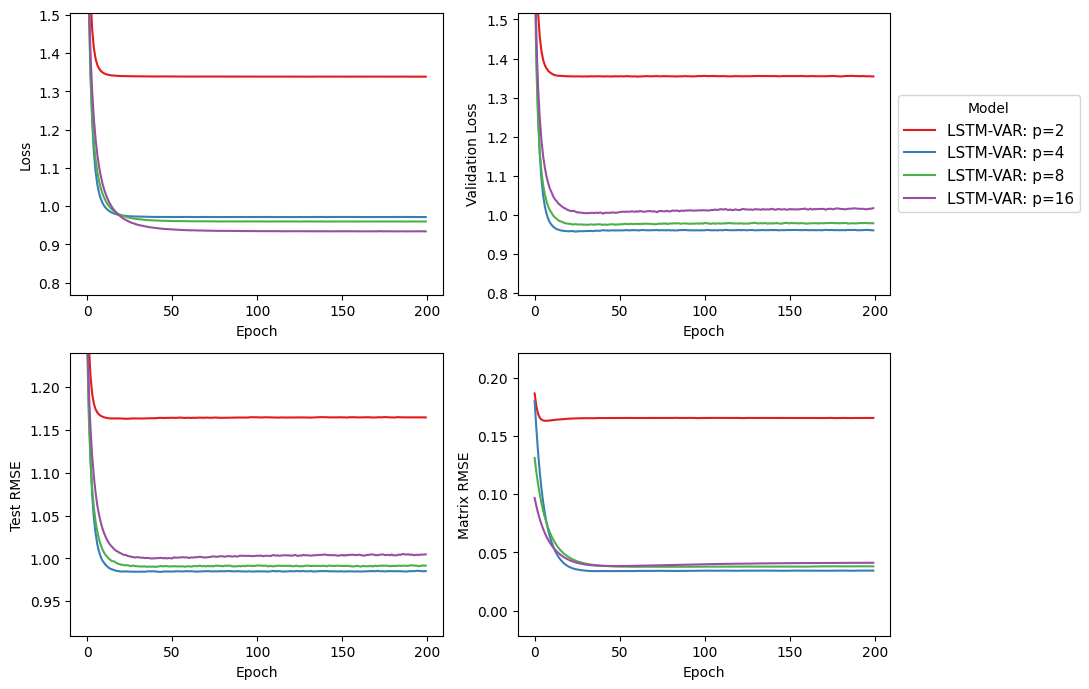

In [7]:
# 1. 2x2 metrics over epochs
fig = plot_performances_over_epochs(metrics, thresholds=[0.1, 0.1, 0.1, 0.1], palette=palette[:len(lstm_vars)])
fig.savefig(test+'/epochs.png')

# Evolution of the loss, validation loss, test RMSE and matrix RMSE over Epochs

In [24]:
var_results.groupby('Model').mean()[['Matrix RMSE', 'Test RMSE', 'Same Sign %']].reindex(vars)

,Matrix RMSE,Test RMSE,Same Sign %
Model,,,
VAR: p=2,0.165518,1.163120,0.700000
VAR: p=4,0.034275,0.982488,0.947222
VAR: p=8,0.038150,0.989188,0.662500
VAR: p=16,0.041509,1.003055,0.591667


In [25]:
metrics.groupby(['Model', 'Epoch']).mean()[['Validation Loss', 'Matrix RMSE', 'Test RMSE',  'Same Sign %']].reset_index().groupby(['Model']).min().reindex(lstm_vars)

,Epoch,Validation Loss,Matrix RMSE,Test RMSE,Same Sign %
Model,,,,,
LSTM-VAR: p=2,0,1.353701,0.163070,1.162954,0.663889
LSTM-VAR: p=4,0,0.956526,0.033924,0.984193,0.677778
LSTM-VAR: p=8,0,0.973783,0.037610,0.990072,0.586111
LSTM-VAR: p=16,0,1.002660,0.038235,0.999689,0.535417


## Gradient analysis
Kernel = what handles the X
Reccurent Kernel = what handles the cell state

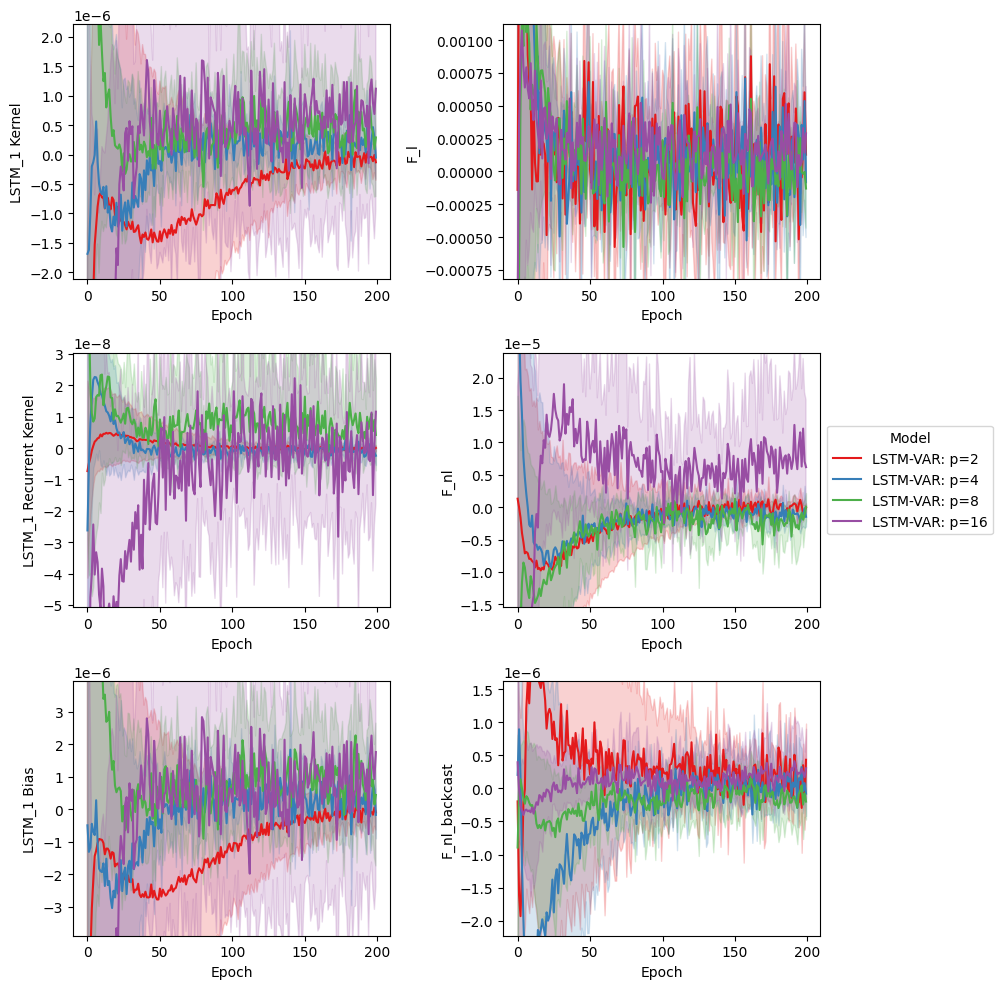

In [26]:
# 2. Gradient over epochs
fig = plot_gradients_over_epochs(gradients, palette[:len(lstm_vars)])
fig.savefig(test+'/gradients.png')

# Evolution of Gradients with Standard Deviation

## Convergence analysis
Table with mean (std), % difference (std) for matrix and val loss.

In [8]:
# 3. Convergence table
converge = compute_convergence(metrics)
table = converge_to_latex_table(converge, lstm_vars)
print(table.style.to_latex())
# Convergence Metrics and Relative Change Across LSTM-VAR Models

Means: Validation Convergence  mean    29.5000
                        std      9.1100
Matrix Convergence      mean    41.8000
                        std     17.2750
Ratio                   mean     1.3925
                        std      0.4250
dtype: float64
\begin{tabular}{llll}
 & Validation Convergence & Matrix Convergence & Ratio \\
Model &  &  &  \\
LSTM-VAR: p=2 & 21.2 (5.79) & 17.1 (5.51) & 0.86 (0.33) \\
LSTM-VAR: p=4 & 26.7 (6.57) & 45.7 (19.38) & 1.72 (0.68) \\
LSTM-VAR: p=8 & 32.3 (11.93) & 53.8 (22.81) & 1.65 (0.36) \\
LSTM-VAR: p=16 & 37.8 (12.15) & 50.6 (21.4) & 1.34 (0.33) \\
\end{tabular}


Statistical test to see if the relative change between convergences is significantly different between models

In [9]:
# 4. Convergence differences statistical test
groups = converge.groupby('Simulation')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between simulations')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")

groups = converge.groupby('Model')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between models')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")
print('Ratio Q3:', converge['Ratio'].quantile(0.90))

Between simulations
P-value: 0.13421336028352399 --- F-statistic: 1.69427769159987
Between models
P-value: 0.00045192208065460723 --- F-statistic: 7.625846224335503
Ratio Q3: 1.9089032258064518


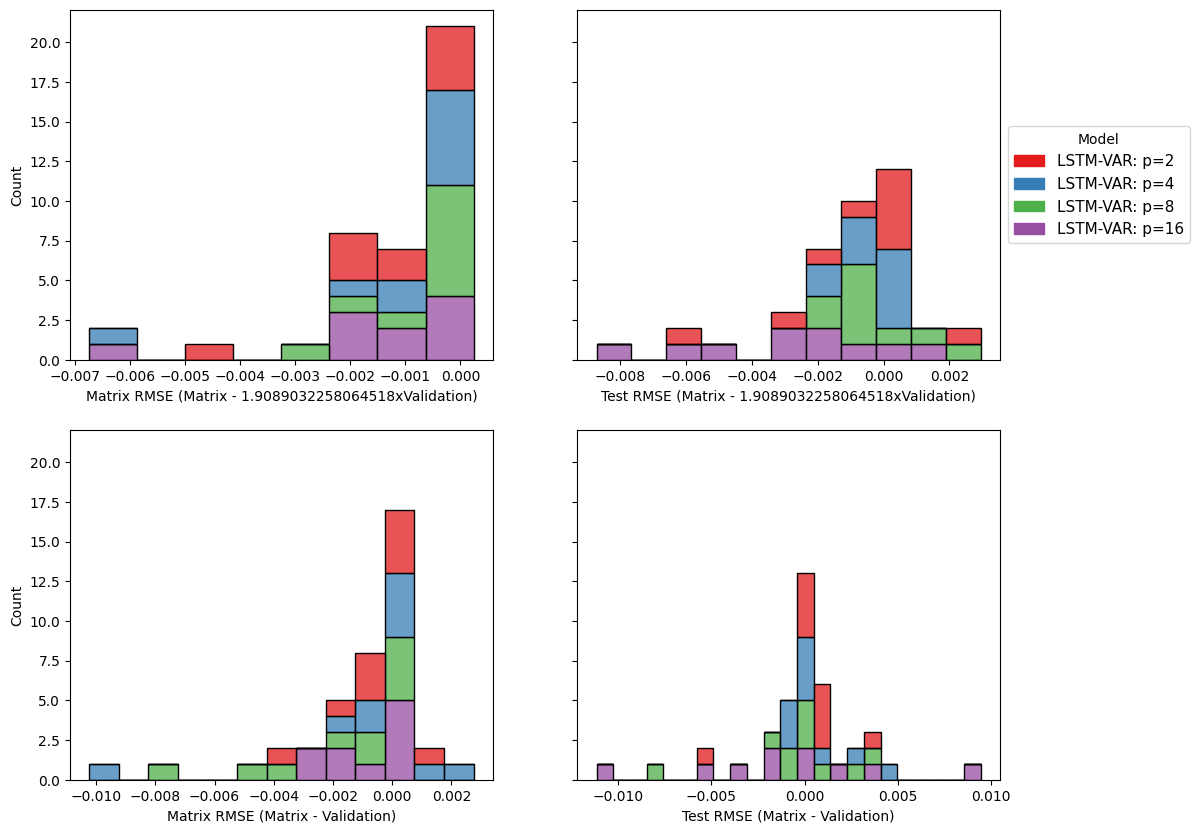

In [10]:
# 5. Convergence metric differences histogram
q3 = np.round(converge['Ratio'].quantile(0.90), 2)
est = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Validation Convergence']*q3, lstm_vars) # Using Q3 of ratio
mat = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Matrix Convergence'], lstm_vars)
val = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Validation Convergence'], lstm_vars)

# Difference between matrix and estimated convergence and between matrix and validation convergence
test_diff = mat[['Matrix RMSE', 'Test RMSE', 'Model', 'Simulation']].reset_index(drop=True)
test_diff.loc[:, f'Test RMSE (Matrix - {q3}xValidation)'] = test_diff['Test RMSE'] - est['Test RMSE']
test_diff.loc[:, f'Matrix RMSE (Matrix - {q3}xValidation)'] = test_diff['Matrix RMSE'] - est['Matrix RMSE']
test_diff.loc[:, 'Test RMSE (Matrix - Validation)'] = test_diff['Test RMSE'] - val['Test RMSE']
test_diff.loc[:, 'Matrix RMSE (Matrix - Validation)'] = test_diff['Matrix RMSE'] - val['Matrix RMSE']
# Re-order
min_diff = order_df((est.sort_values(by=['Model', 'Simulation']).set_index(['Model','Simulation'])[['Matrix RMSE', 'Test RMSE']] - metrics.groupby(['Model', 'Simulation']).min()[['Matrix RMSE', 'Test RMSE']]).reset_index(), lstm_vars)

fig = plot_convergence_differences(
    [{'df':[test_diff, test_diff], 'columns':[f'Matrix RMSE (Matrix - {q3}xValidation)', f'Test RMSE (Matrix - {q3}xValidation)'], 'hue':'Model', 'legend':True, 'palette': palette[:len(lstm_vars)]},
     {'df':[test_diff, test_diff], 'columns':['Matrix RMSE (Matrix - Validation)', 'Test RMSE (Matrix - Validation)'], 'hue':'Model', 'legend':False, 'palette': palette[:len(lstm_vars)]}])
fig.savefig(test+'/convdiff.png')

# Histograms of Differences in Convergence Metrics

In [11]:
print(test_diff.describe()[['Matrix RMSE (Matrix - Validation)', f'Matrix RMSE (Matrix - {q3}xValidation)', 'Test RMSE (Matrix - Validation)', f'Test RMSE (Matrix - {q3}xValidation)']].loc[['min','max']])

     Matrix RMSE (Matrix - Validation)  \
min                          -0.010232   
max                           0.002745   

     Matrix RMSE (Matrix - 1.9089032258064518xValidation)  \
min                                          -0.006735      
max                                           0.000237      

     Test RMSE (Matrix - Validation)  \
min                        -0.011159   
max                         0.009441   

     Test RMSE (Matrix - 1.9089032258064518xValidation)  
min                                          -0.008722   
max                                           0.002952   


## Convergence results

Table of model, matrix sim, test mse (mean (std)), % difference
Table of statistical tests
Heatmap or joyplot plot of variable and lag eucl dist (2 parts)

In [12]:
# 6. Results table
results = pd.concat([val.drop(columns=['Loss', 'Validation Loss', 'Epoch']), var_results])
table = results_to_latex_table(results, lstm_vars, vars)
print(table[['Matrix RMSE', 'Test RMSE']].style.to_latex())

print(table[['Same Sign %']].style.to_latex())
# Performance of LSTM-VAR Models and VAR Models

\begin{tabular}{lllll}
 & \multicolumn{2}{r}{Matrix RMSE} & \multicolumn{2}{r}{Test RMSE} \\
 & Mean & Change (vs VAR) & Mean & Change (vs VAR) \\
Model &  &  &  &  \\
VAR: p=2 & 0.166 (0.036) & - & 1.163 (0.114) & - \\
VAR: p=4 & 0.034 (0.004) & - & 0.982 (0.058) & - \\
VAR: p=8 & 0.038 (0.004) & - & 0.989 (0.056) & - \\
VAR: p=16 & 0.042 (0.004) & - & 1.003 (0.059) & - \\
LSTM-VAR: p=2 & 0.165 (0.036) & 0.488\% & 1.162 (0.111) & 0.064\% \\
LSTM-VAR: p=4 & 0.034 (0.005) & 1.017\% & 0.984 (0.058) & -0.127\% \\
LSTM-VAR: p=8 & 0.038 (0.006) & 0.537\% & 0.991 (0.056) & -0.135\% \\
LSTM-VAR: p=16 & 0.037 (0.004) & 9.755\% & 1.0 (0.06) & 0.289\% \\
\end{tabular}

\begin{tabular}{lll}
 & \multicolumn{2}{r}{Same Sign %} \\
 & Mean & Change (vs VAR) \\
Model &  &  \\
VAR: p=2 & 0.7 (0.058) & - \\
VAR: p=4 & 0.947 (0.046) & - \\
VAR: p=8 & 0.662 (0.027) & - \\
VAR: p=16 & 0.592 (0.031) & - \\
LSTM-VAR: p=2 & 0.703 (0.056) & -0.397\% \\
LSTM-VAR: p=4 & 0.939 (0.054) & 0.88\% \\
LSTM-VAR: p=8 & 

In [13]:
# 7. Results p-values table
table = compute_p_values(results, lstm_vars, counterparts)

print(table[['Matrix RMSE', 'Test RMSE']].style.to_latex())
print(table[['Same Sign %']].style.to_latex())
# Statistical Test Results for LSTM-VAR Models vs. VAR Model

\begin{tabular}{lllll}
p-value of & \multicolumn{2}{r}{Matrix RMSE} & \multicolumn{2}{r}{Test RMSE} \\
against & VAR & True model & VAR & True model \\
LSTM-VAR: p=2 & *0.012 & *0.000 & 0.496 & *0.000 \\
LSTM-VAR: p=4 & 0.840 & - & 0.146 & - \\
LSTM-VAR: p=8 & 0.891 & *0.009 & 0.511 & *0.009 \\
LSTM-VAR: p=16 & *0.001 & *0.018 & 0.381 & *0.001 \\
\end{tabular}

\begin{tabular}{lll}
p-value of & \multicolumn{2}{r}{Same Sign %} \\
against & VAR & True model \\
LSTM-VAR: p=2 & 0.343 & *0.000 \\
LSTM-VAR: p=4 & 0.343 & - \\
LSTM-VAR: p=8 & 0.671 & *0.000 \\
LSTM-VAR: p=16 & 0.879 & *0.000 \\
\end{tabular}


## Variable-wise and lag-wise RMSE

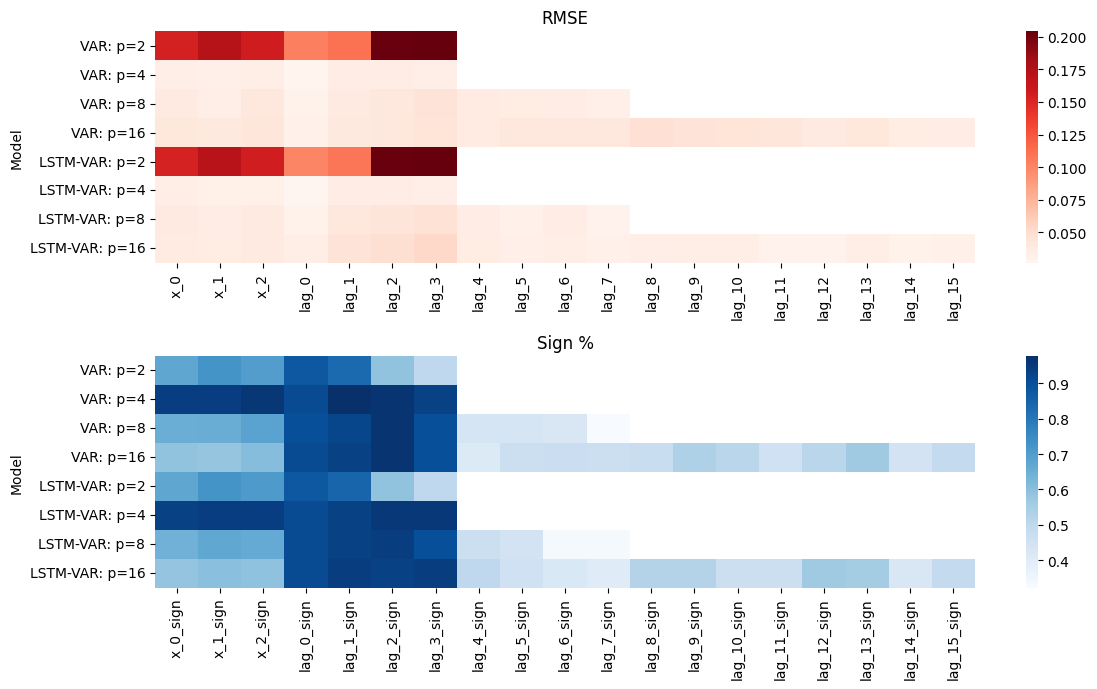

In [14]:
# 8. Variable wise and lag wise heatmap
fig = plot_heatmap(results, vars, lstm_vars)
fig.savefig(test+'/lags_n_vars.png')

## Forecast breakdown

In [17]:
# 9. Breakdown of forecasts

# Read all models in test/models
models = {file:keras.models.load_model(test+'/models/'+file) for file in os.listdir(test+'/models')}
print(models.keys())

dict_keys(['LSTM-VAR p=16', 'LSTM-VAR p=2', 'LSTM-VAR p=4', 'LSTM-VAR p=8'])


In [20]:
# TODO Pick model and what you want to plot
model = models[f'LSTM-VAR p=2']
p = 2
time_series = 0 # 0 to m-1
dgp = 'v' # v, t, s, vt, vs, ts, vts


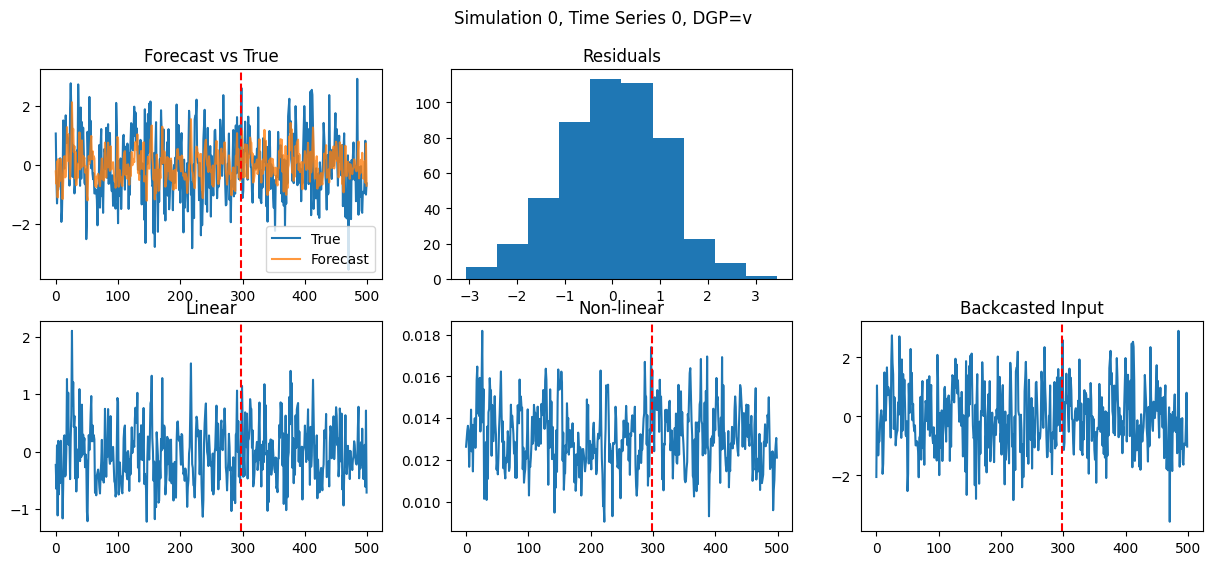

In [21]:
simulation = simulate(n, m, p, seed=0)
dataset = DataSet(simulation[dgp].values).preprocessing(1, p, 0.8, 0.1, scale=False)

fig = plot_forecast_breakdown(model, dataset, time_series, dgp)